# Preprocessing: Cropping, Interpolation, and Concatenation

Data streams from Neon devices (gaze, eye states, IMU) present three common challenges:
1. **Irregular sampling**: Device limitations cause non-uniform time intervals between samples
2. **Different sampling rates**: Each stream type has its own nominal frequency (gaze: 200 Hz, eye states: 200 Hz, IMU: 110 Hz)
3. **Misaligned timestamps**: Streams may start and end at different times

This tutorial shows how to address these challenges using PyNeon's preprocessing tools: `crop()` and `restrict()` for temporal selection, `interpolate()` for resampling, and `concat_streams()` for combining multiple streams. We use the same dataset as in the [previous tutorial](read_recording_cloud.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyneon import Dataset, get_sample_data

dataset = Dataset(get_sample_data("simple", format="native"))

Load the gaze, eye states, and IMU streams from the recording. Each `Stream` object contains continuous time-series data indexed by nanosecond-precision timestamps.

In [2]:
rec = dataset.recordings[0]
gaze = rec.gaze
eye_states = rec.eye_states
imu = rec.imu


# Define a function to visualize the timestamp distribution across streams
def plot_timestamps(gaze, eye_states, imu, concat_stream=None):
    _, ax = plt.subplots(figsize=(8, 2))
    ax.scatter(gaze.ts, np.ones_like(gaze.ts), s=5)
    ax.scatter(eye_states.ts, np.ones_like(eye_states.ts) * 2, s=5)
    ax.scatter(imu.ts, np.ones_like(imu.ts) * 3, s=5)
    # If a concatenated stream (explained later) is provided, plot its timestamps as well
    if concat_stream is not None:
        ax.scatter(concat_stream.ts, np.ones_like(concat_stream.ts) * 4, s=5)
        ax.set_yticks([1, 2, 3, 4])
        ax.set_yticklabels(["Gaze", "Eye states", "IMU", "Concatenated"])
        ax.set_ylim(0.5, 4.5)
    else:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(["Gaze", "Eye states", "IMU"])
        ax.set_ylim(0.5, 3.5)
    ax.set_xlabel("Timestamp (ns)")
    plt.show()

## Selecting Time Windows with `crop()` and `restrict()`

Analyzing specific time windows requires selecting subsets of your data. PyNeon provides two complementary methods:
- **`crop()`**: Extract data within a specified temporal range
- **`restrict()`**: Align one stream to match another's temporal boundaries

### Using `crop()` to Extract Time Ranges

The `crop()` method accepts `tmin` and `tmax` bounds (both inclusive). The `by` parameter determines how these bounds are interpreted:
- `by="timestamp"`: Absolute Unix timestamps in nanoseconds
- `by="time"`: Relative time in seconds from the stream's first sample
- `by="sample"`: Zero-based sample indices

Let's crop the gaze stream to the start of the recording::

In [3]:
# Crop to the first 0.3 seconds of gaze data using relative time
gaze_300ms = gaze.crop(tmin=0, tmax=0.3, by="time")
# Alternatively, crop to the first 200 data points
gaze_200samples = gaze.crop(tmin=0, tmax=200, by="sample")

print(f"Gaze stream length before cropping: {len(gaze)}")
print(f"Gaze stream length after cropping (0.3 seconds): {len(gaze_300ms)}")
print(f"Gaze stream length after cropping (200 samples): {len(gaze_200samples)}")

Gaze stream length before cropping: 1048
Gaze stream length after cropping (0.3 seconds): 60
Gaze stream length after cropping (200 samples): 201


### Using `restrict()` to Align Streams

The `restrict()` method aligns one stream to match another's temporal boundaries. It's a convenience wrapper equivalent to `crop(tmin=other.first_ts, tmax=other.last_ts, by="timestamp")`.

This is particularly useful when streams have different start/end times. In our recording, the raw IMU stream starts earlier than gaze and eye states:

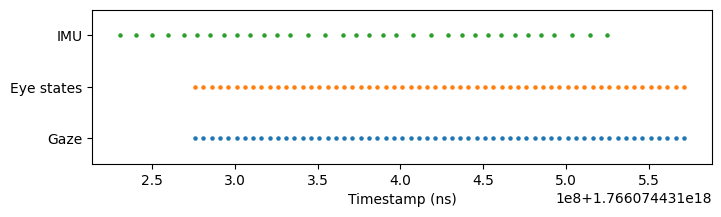

In [4]:
plot_timestamps(
    gaze_300ms, eye_states.crop(tmax=0.3, by="time"), imu.crop(tmax=0.3, by="time")
)

Use `restrict()` to trim the eye states and IMU data to match gaze's temporal range:

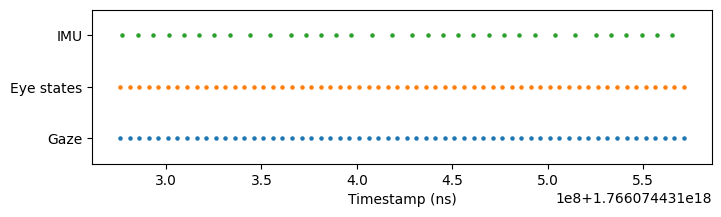

In [5]:
# Restrict eye_states and imu data to match gaze_300ms's time range
eye_states_300ms = eye_states.restrict(gaze_300ms)
imu_300ms = imu.restrict(gaze_300ms)

plot_timestamps(gaze_300ms, eye_states_300ms, imu_300ms)

## Understanding Sampling Irregularities

To quantify sampling irregularities, let's examine the distribution of time intervals between consecutive samples and compare them to the nominal sampling rates specified by Pupil Labs:

Nominal sampling frequency of gaze: 200 Hz. Actual: 199.1 Hz
Nominal sampling frequency of eye states: 200 Hz. Actual: 199.1 Hz
Nominal sampling frequency of IMU: 110 Hz. Actual: 114.7 Hz


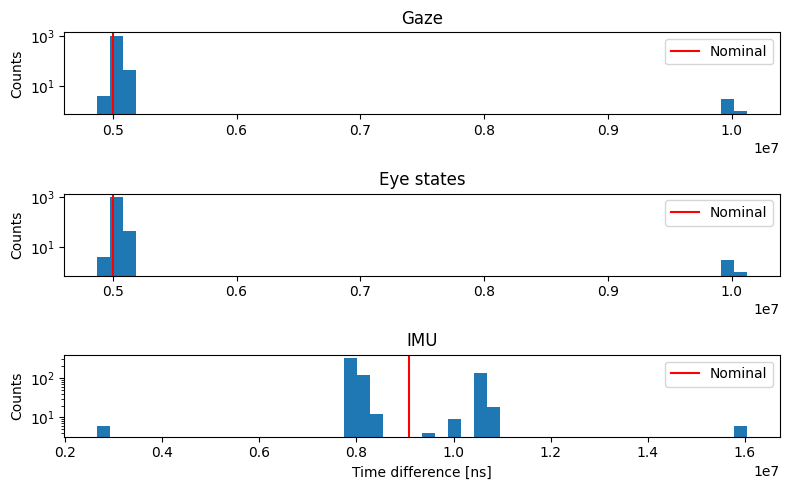

In [6]:
print(
    f"Nominal sampling frequency of gaze: {gaze.sampling_freq_nominal} Hz. "
    f"Actual: {gaze.sampling_freq_effective:.1f} Hz"
)
print(
    f"Nominal sampling frequency of eye states: {eye_states.sampling_freq_nominal} Hz. "
    f"Actual: {eye_states.sampling_freq_effective:.1f} Hz"
)
print(
    f"Nominal sampling frequency of IMU: {imu.sampling_freq_nominal} Hz. "
    f"Actual: {imu.sampling_freq_effective:.1f} Hz"
)

fig, axs = plt.subplots(3, 1, figsize=(8, 5), tight_layout=True)

axs[0].hist(gaze.ts_diff, bins=50)
axs[0].axvline(1e9 / gaze.sampling_freq_nominal, c="red", label="Nominal")
axs[0].set_title("Gaze")

axs[1].hist(eye_states.ts_diff, bins=50)
axs[1].axvline(1e9 / eye_states.sampling_freq_nominal, c="red", label="Nominal")
axs[1].set_title("Eye states")

axs[2].hist(imu.ts_diff, bins=50)
axs[2].axvline(1e9 / imu.sampling_freq_nominal, c="red", label="Nominal")
axs[2].set_title("IMU")
axs[2].set_xlabel("Time difference [ns]")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.show()

The histograms reveal that while most intervals cluster around the nominal rate (red line), all three streams show irregularities:
- **Gaze and eye states**: Integer multiples of the nominal interval indicate occasional dropped frames from the eye camera
- **IMU**: Broader distribution suggests more variable sampling intervals

These irregularities motivate the need for interpolation when analyses require uniform sampling.

## Resampling to Uniform Timestamps with `interpolate()`

Many analyses require uniformly-sampled data. The `interpolate()` method resamples streams to regular intervals using `scipy.interpolate.interp1d` [(API reference)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).

By default, `interpolate()` generates uniformly-spaced timestamps at the stream's nominal sampling frequency (200 Hz for gaze/eye states, 110 Hz for IMU), starting from the first sample and ending at the last.

In [7]:
# Interpolate to the nominal sampling frequency
gaze_interp = gaze.interpolate()

# Three ways you can check if the interpolation was successful:
# 1. Compare the effective sampling frequency to the nominal sampling frequency
print(
    f"Nominal sampling frequency of gaze: {gaze_interp.sampling_freq_nominal} Hz. "
    f"Actual (after interpolation): {gaze_interp.sampling_freq_effective:.1f} Hz"
)
# 2. Check the number of unique time differences
print(f"Only one unique time difference: {np.unique(gaze_interp.ts_diff)}")
# 3. Call the `is_uniformly_sampled` property (boolean)
print(f"The new gaze stream is uniformly sampled: {gaze_interp.is_uniformly_sampled}")
print(gaze_interp.data.dtypes)

Nominal sampling frequency of gaze: 200 Hz. Actual (after interpolation): 200.0 Hz
Only one unique time difference: [5000000]
The new gaze stream is uniformly sampled: True
gaze x [px]        float64
gaze y [px]        float64
worn               float64
azimuth [deg]      float64
elevation [deg]    float64
dtype: object


Column data types are preserved during interpolation. You can also resample to custom timestamps using the `new_ts` parameter—useful for synchronizing streams with different sampling rates. For example, resample gaze data (~200 Hz) to IMU timestamps (~110 Hz):

In [8]:
print(f"Original gaze data length: {len(gaze)}")
print(f"Original IMU data length: {len(imu)}")
gaze_interp_to_imu = gaze.interpolate(new_ts=imu.ts)
print(
    f"Gaze data length after interpolating to IMU timestamps: {len(gaze_interp_to_imu)}"
)

Original gaze data length: 1048
Original IMU data length: 622
Gaze data length after interpolating to IMU timestamps: 622


C:\Users\User\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:67: UserWarning: 18 out of 622 requested timestamps are outside the data time range and will have empty data.
  warn(


The warning above is expected: remember that IMU recording starts earlier than gaze, so interpolating gaze to IMU timestamps will include extrapolation for the initial IMU samples. The resulting `interpolated_gaze` stream contains values at all IMU timestamps, with NaNs for timestamps outside the original gaze range.

### How Interpolation Works

By default, float columns use linear interpolation (`float_kind='linear'`), while non-float columns use nearest-neighbor (`other_kind='nearest'`). Linear interpolation estimates values at new timestamps by drawing straight lines between existing data points:

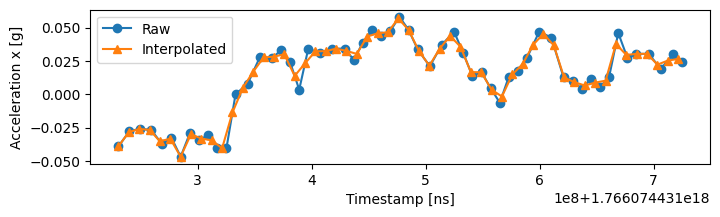

In [9]:
imu_500ms = imu.crop(tmax=0.5, by="time")

plt.figure(figsize=(8, 2))
plt.plot(imu_500ms["acceleration x [g]"], marker="o", label="Raw")
plt.plot(
    imu_500ms.interpolate()["acceleration x [g]"],
    marker="^",
    label="Interpolated",
)
plt.xlabel("Timestamp [ns]")
plt.ylabel("Acceleration x [g]")
plt.legend()
plt.show()

Interpolation creates new uniformly-spaced samples (orange triangles) while preserving most original data points (blue circles) that happen to fall near the new timestamps.

## Combining Streams with `concat_streams()`

Joint analysis of multiple sensors requires combining streams into a single DataFrame. The `concat_streams()` method:

1. Determines the common temporal overlap (from the latest start to the earliest end across all streams)
2. Interpolates all streams to uniform timestamps within this range
3. Combines columns into a single `Stream` object

The sampling rate defaults to the lowest nominal frequency among the selected streams (110 Hz when including IMU).

In [10]:
concat_stream = rec.concat_streams(["gaze", "eye_states", "imu"])
print(concat_stream.data.head())
print(concat_stream.data.columns)

Concatenating streams:
	gaze
	eye_states
	imu
Using lowest sampling rate: 110 Hz (<StringArray>
['imu']
Length: 1, dtype: str)
Using latest start timestamp: 1766074431275967547 (<StringArray>
['gaze', 'eye_states']
Length: 2, dtype: str)
Using earliest last timestamp: 1766074436535834547 (<StringArray>
['gaze', 'eye_states']
Length: 2, dtype: str)
                     gaze x [px]  gaze y [px]  worn  azimuth [deg]  \
timestamp [ns]                                                       
1766074431275967547   731.885864   503.253845    -1      -4.384848   
1766074431285058456   735.780922   499.996515    -1      -4.134103   
1766074431294149365   735.862011   502.149531    -1      -4.128883   
1766074431303240274   737.018387   503.200361    -1      -4.054441   
1766074431312331183   739.273033   502.726029    -1      -3.909299   

                     elevation [deg]  pupil diameter left [mm]  \
timestamp [ns]                                                   
1766074431275967547        

Compare a 0.3-second window from the middle of the recording. The concatenated stream (bottom row) shows perfectly uniform timestamps that roughly matches the sampling rate of IMU (110 Hz).

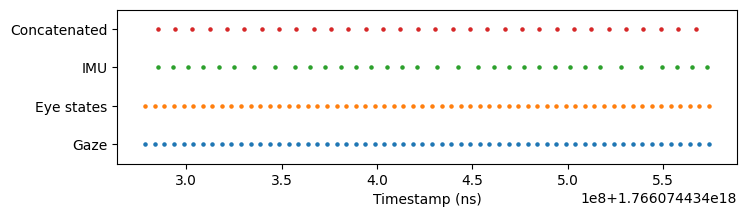

In [11]:
# Extract a time window from the middle of the recording to highlight sampling differences
gaze_middle = gaze.crop(tmin=3.0, tmax=3.3, by="time")
eye_states_middle = eye_states.restrict(gaze_middle)
imu_middle = imu.restrict(gaze_middle)
concat_stream_middle = concat_stream.restrict(gaze_middle)
plot_timestamps(gaze_middle, eye_states_middle, imu_middle, concat_stream_middle)

Despite resampling to uniform timestamps, interpolation preserves the data's essential characteristics. Comparing the same columns before (blue circles) and after (orange triangles) concatenation shows how values remain faithful to the originals:

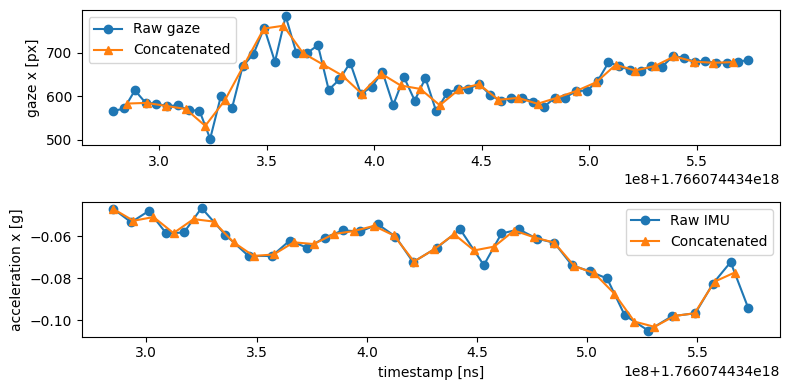

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)
axs[0].plot(
    gaze_middle["gaze x [px]"],
    marker="o",
    label="Raw gaze",
)
axs[0].plot(
    concat_stream_middle["gaze x [px]"],
    marker="^",
    label="Concatenated",
)
axs[0].set_ylabel("gaze x [px]")
axs[0].legend()
axs[1].plot(
    imu_middle["acceleration x [g]"],
    marker="o",
    label="Raw IMU",
)
axs[1].plot(
    concat_stream_middle["acceleration x [g]"],
    marker="^",
    label="Concatenated",
)
axs[1].set_ylabel("acceleration x [g]")
axs[1].set_xlabel("timestamp [ns]")
axs[1].legend()
plt.show()